### В данной работе разработана модель вариационного автокодировщика

In [9]:
#В данной работе использую Python 3.7.9 и Tensorflow 1.15

import sys
import tensorflow as tf
from tensorflow import keras 

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Вывод версий Python и Tensorflow
print("Python", sys.version)
print("Tensorflow", tf.__version__)

Python 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
Tensorflow 1.15.0


### Импорт библиотек и загрузка датасета MNIST

In [ ]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
np.random.seed(42)
tf.set_random_seed(42)
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data')
input_size = 28 * 28
num_digits = 10

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### Определение гиперпараметров модели
Настраиваются параметры обучения: количество эпох, размер скрытого пространства, структура слоёв энкодера, декодера и классификатора, вес функции потерь классификации, скорость обучения и т.д.

In [ ]:
params = {
# кодировщик на простой сети прямого распространения
'encoder_layers': [128],
# как и декодер (CNN лучше, но не хочу усложнять код)
'decoder_layers': [128],
# нужно для условий, разобранных далее
'digit_classification_layers': [128],
# функция активации используется всеми подсетями
'activation': tf.nn.sigmoid,
# стандартное отклонение P(x|z) обсуждалось выше
'decoder_std': 0.5,
# размерность скрытого пространства
'z_dim': 10,
# нужно для условий, разобранных далее
'digit_classification_weight': 10.0,
'epochs': 10,
'batch_size': 100,
'learning_rate': 0.001
}

### Определение архитектуры VAE
Реализуются три функции: 
* `encoder` — кодирует изображение в скрытое пространство; 
* `decoder` — восстанавливает изображение из скрытого вектора; 
* `digit_classifier` — классифицирует изображение по цифре.

In [ ]:
def encoder(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
        mu = tf.layers.dense(x, params['z_dim'])
        var = 1e-5 + tf.exp(tf.layers.dense(x, params['z_dim']))
    return mu, var

def decoder(z, layers):
    for layer in layers:
        z = tf.layers.dense(z, layer, activation=params['activation'])
        mu = tf.layers.dense(z, input_size)
    return tf.nn.sigmoid(mu)

def digit_classifier(x, layers):
    for layer in layers:
        x = tf.layers.dense(x, layer, activation=params['activation'])
        logits = tf.layers.dense(x, num_digits)
    return logits

images = tf.placeholder(tf.float32, [None, input_size])
digits = tf.placeholder(tf.int32, [None])

# кодируем изображение в распределение по скрытому пространству
encoder_mu, encoder_var = encoder(images,
params['encoder_layers'])

# отбираем вектор из скрытого пространства, используя трюк с повторной параметризацией
eps = tf.random_normal(shape=[tf.shape(images)[0], params['z_dim']],
mean=0.0, stddev=1.0)
z = encoder_mu + tf.sqrt(encoder_var) * eps

# Классифицируем цифры
digit_logits = digit_classifier(images,
params['digit_classification_layers'])
digit_prob = tf.nn.softmax(digit_logits)

# Декодируем в изображение скрытый вектор, связанный с классификацией цифр
decoded_images = decoder(tf.concat([z, digit_prob], axis=1),
params['decoder_layers'])

# потеря состоит в том, насколько хорошо можем восстановить изображение
loss_reconstruction = -tf.reduce_sum(
    tf.contrib.distributions.Normal(decoded_images,
                                    params['decoder_std']).log_prob(images),axis=1)

# и как далеко распределение по скрытому пространству 
#  от предыдущего. Если предыдущее является
# стандартным гауссовским распределением, а
# в результате получается нормальное распределение
# с диагональной конвариантной матрицей, то
# KL-расхождение становится аналитически разрешимым,и получаем
loss_prior = -0.5 * tf.reduce_sum(1 + tf.log(encoder_var) -
encoder_mu ** 2 - encoder_var, axis=1)
loss_auto_encode = tf.reduce_mean(loss_reconstruction +
loss_prior,axis=0)
loss_digit_classifier = params['digit_classification_weight'] * tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=digits, logits=digit_logits), axis=0)
loss = loss_auto_encode + loss_digit_classifier
train_op = tf.train.AdamOptimizer(params['learning_rate']).minimize(loss)

### Обучение модели
Проходит цикл по эпохам. На каждом шаге обучается модель, затем считается ошибка на всём наборе и сохраняются изображения, сгенерированные моделью на основе скрытых векторов и меток

In [28]:
print("Количество образов в MNIST:", mnist.train.num_examples)
print("Размер батча:", params['batch_size'])
print("Обучение в течение эпох:", params['epochs'])

samples = []
losses_auto_encode = []
losses_digit_classifier = []
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

for epoch in range(params['epochs']):
    for _ in range(int(mnist.train.num_examples / params['batch_size'])):
        batch_images, batch_digits = mnist.train.next_batch(params['batch_size'])
        sess.run(train_op, feed_dict={images: batch_images, digits: batch_digits})
    train_loss_auto_encode, train_loss_digit_classifier = sess.run([loss_auto_encode, loss_digit_classifier], 
                                                                   {images: mnist.train.images, digits: mnist.train.labels})
    losses_auto_encode.append(train_loss_auto_encode)
    losses_digit_classifier.append(train_loss_digit_classifier)
    sample_z = np.tile(np.random.randn(1, params['z_dim']), reps=[num_digits, 1])
    gen_samples = sess.run(decoded_images, feed_dict={z: sample_z, digit_prob: np.eye(num_digits)})
    samples.append(gen_samples)

print("Обучение завершено")


Количество образов в MNIST: 55000
Размер батча: 100
Обучение в течение эпох: 10
Device mapping:



Обучение завершено


### Визуализация графиков потерь

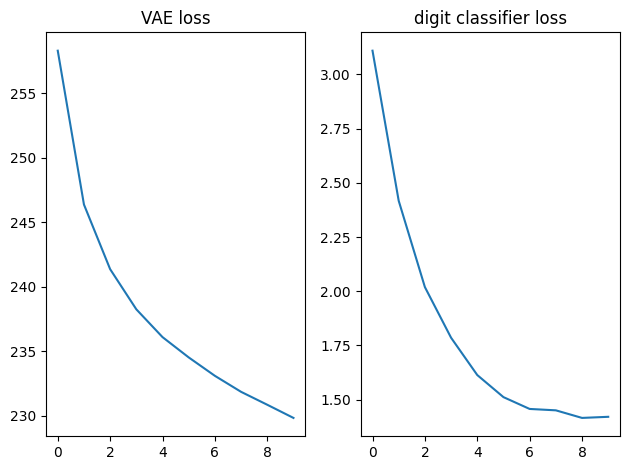

In [29]:
plt.subplot(121)
plt.plot(losses_auto_encode)
plt.title('VAE loss')
plt.subplot(122)
plt.plot(losses_digit_classifier)
plt.title('digit classifier loss')
plt.tight_layout()

### Визуализация сгенерированных изображений

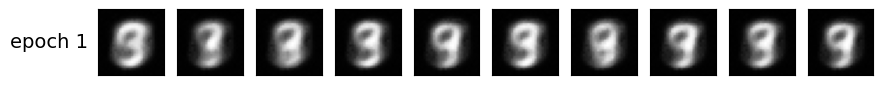

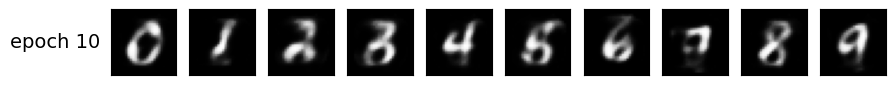

In [32]:
def plot_samples(samples, epoch):
    IMAGE_WIDTH = 1
    plt.figure(figsize=(IMAGE_WIDTH * num_digits * 1, IMAGE_WIDTH * num_digits))
    for digit, image in enumerate(samples[epoch]):
        plt.subplot(1, num_digits, digit + 1)
        plt.imshow(image.reshape((28, 28)), cmap='Greys_r')
        plt.gca().xaxis.set_visible(False)
        if digit == 0:
            plt.gca().yaxis.set_ticks([])
            plt.ylabel('epoch {}'.format(epoch + 1),
                verticalalignment='center',
                horizontalalignment='right',
                rotation=0,
                fontsize=14)
        else:
            plt.gca().yaxis.set_visible(False)
            
plot_samples(samples, 0)
plot_samples(samples, len(samples)-1)